# Data Fitting and Interpolation

The scientific method is based on empiricism, which requires the collection of evidence (data) through an experiment to test a hypothesis.  After the data is collected a scientist needs to synthesize the result by comparing (fitting) the data to predictions made by existing theories or models.  Thus, data fitting is an art worthy by all scientists.  In this chapter, we will discuss two methods of interpolation (e.g., Lagrange and Cubic Splines), least squares fitting, and maximum likelihood estimation.

## Fitting an experimental spectrum (Problem)
 The cross sections (in millibarns; mb) for the resonant scattering of a neutron from a nucleus (see Table {numref}`{number}<cross-section-table>`) can be measured in terms of the energy with an associated experimental error.  Your problem is to determine the values for the cross sections at energy values lying between the measured values.  

```{list-table} Experimental values for a scattering cross section, each with an absolute error $\pm \sigma_i$, as a function of energy.
:header-rows: 1
:name: cross-section-table

* - i
  - 1
  - 2
  - 3
  - 4
  - 5
  - 6
  - 7
  - 8
  - 9
* - $E_i$ (MeV)
  - 0
  - 25
  - 50
  - 75
  - 100
  - 125
  - 150
  - 175
  - 200
* - $g(E_i)$ (mb)
  - 10.6
  - 16.0
  - 45.0
  - 83.5
  - 52.8
  - 19.9
  - 10.8
  - 8.25
  - 4.7
* - Error (mb)
  - 9.34
  - 17.9
  - 41.5
  - 85.5
  - 51.5
  - 21.5
  - 10.8
  - 6.29
  - 4.14
```

You can solve this problem in a number of ways, where the simplest is to numerically *interpolate* between the values of $g(E_i)$.  This is direct and easy, but does not account for the experimental noise in the data.  A more appropriate way to solve this problem is to find the *best fit* of a theoretical function to the data.  The best fit depends on a series of model parameters that are tweaked so that the distance between the experimental points and the model curve is minimized relative to the measurement uncertainty.  In the meantime, let's see how this data looks graphically.

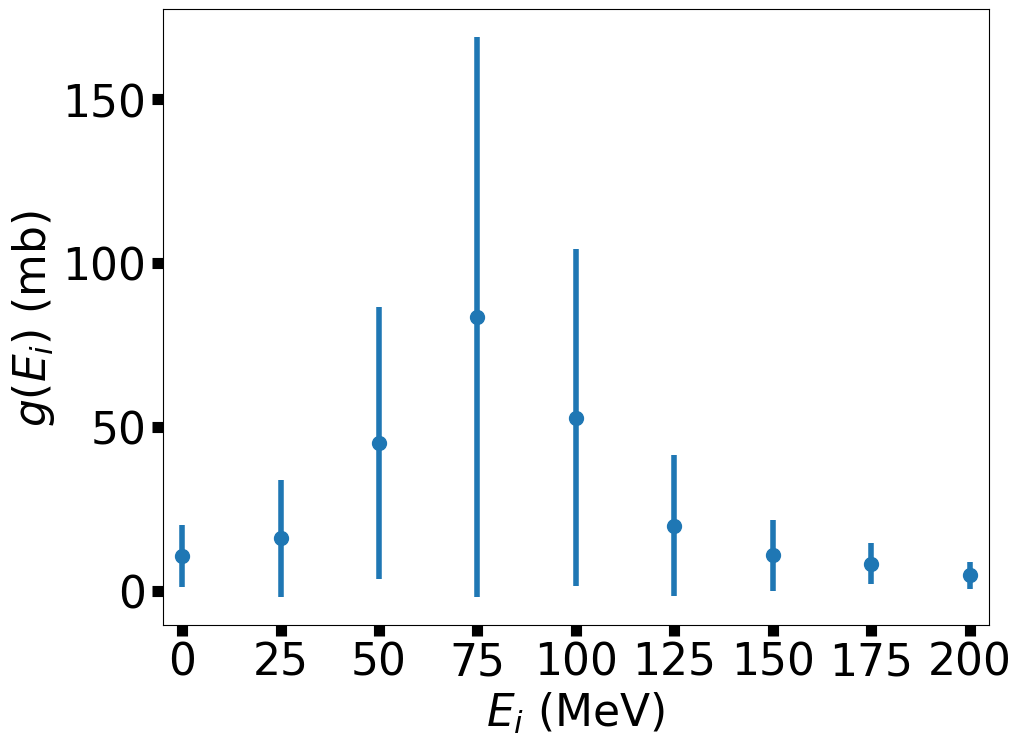

In [6]:
#plot_Table2_1.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

#set default fontsize
rcParams.update({'font.size': 22})

aspect = 4./3.
fs = 'x-large'

xvals = np.arange(0,225,25)
yvals = np.array([10.6,16,45,83.5,52.8,19.9,10.8,8.25,4.7])
yerror = np.array([9.34,17.9,41.5,85.5,51.5,21.5,10.8,6.29,4.14])

fig = plt.figure(figsize=(aspect*8,8))
ax = fig.add_subplot(111)

#using the errorbar function from matplotlib
ax.errorbar(xvals,yvals,yerr=yerror,fmt='o',ms=10,lw=4)

ax.set_xlim(-5,205)
ax.set_xticks(xvals)
ax.set_xlabel("$E_i$ (MeV)",fontsize=fs)
ax.set_ylabel("$g(E_i)$ (mb)", fontsize=fs)
ax.tick_params(axis='both', direction='out',length = 8.0, width = 8.0,labelsize=fs)

fig.savefig("neutron_scattering.png",bbox_inches='tight',dpi=300)

In the above figure, one can see that the cross section peaks at 75 MeV, although there is a large measurement uncertainty.

Interpolation and curve-fitting are powerful tools that let you treat tables of numbers as if they were analytic functions and *sometimes* allow you to deduce statistically meaningful constants or conclusions from measurements.  Data fitting can be either *global* or *local*, which describes whether or not a single function is used to represent the entire data set.  An incorrect global fit can introduce spurious features between the data points that are nonphysical.  Keep it local and view global interpolation with a critical eye.

## Linear Interpolation

The easiest method to [interpolate](https://en.wikipedia.org/wiki/Interpolation) data is linearly.  In this section, we will derive the necessary equations and apply them at the end of Section 2.3 to see how a linear interpolation fares.  First, we must recall the equation of a line: $g(x) = a_o + a_1x$, which will be applied to two nearby points ($x_i$ and $x_{i+1}$).  As a result, we find the system of linear equations:

\begin{align}
g(x) &= a_o + a_1x, \\
g(x_i) &= a_o + a_1x_i, \\
 g(x_{i+1}) &= a_o + a_1x_{i+1}.
\end{align}

We can combine all three equations $\left[ g(x),\ g(x_i),\ g(x_{i+1}) \right]$ and solve them analytically (3 equations and 3 unknowns to eliminate the coefficients).  Here, we know $g(x_i)$ and $g(x_{i+1})$ from our table.  Thus, we find:

\begin{align}
g(x) = g(x_i) + \left(\frac{x-x_i}{x_{i+1}-x_i}\right) \left[g(x_{i+1})-g(x_i)\right]
\end{align}

Now it's time to code this up as a function for later.

In [7]:
def linear_interp(x_n,g_n,x):
    #generate value for linear interpolation function
    #x_n = array containing independent values from table
    #g_n = array containing dependent values from table
    #x = value to evaluate
    inner_idx = np.where(x>=x_n)[0] #search to find first point where x > x_n (in table)
    if len(inner_idx)==0:
        inner_idx = 0
    else:
        inner_idx = inner_idx[-1]
    outer_idx = inner_idx+1
    #print(inner_idx,outer_idx)
    if inner_idx != outer_idx:
        return g_n[inner_idx] + (x-x_n[inner_idx])/(x_n[outer_idx]-x_n[inner_idx])*(g_n[outer_idx]-g_n[inner_idx])


## Lagrange Interpolation

Consider Table {numref}`{number}<cross-section-table>` as ordered data that we wish to interpolate.  The energy $E_i$ is the independent variable $x_i$ and the cross section is the dependent variable $g(x_i)$.  We assume there exists a reasonable approximation representing $g(x)$ to model between data points using a $(n-1)$-degree polynomial over an interval $i$:

\begin{align}
g_i(x) \simeq a_0 + a_1 x + a_2 x^2 + \cdot + a_{n-1} x^{n-1},\; (x\simeq x_i).
\end{align}

Because our fit is local, we do not assume that one $g(x)$ can fit all the data in the table, where many sets of $a_i$ exist for each region of the table.  This will include multiple low-degree polynomials that span the entire table.  With some care, the set of polynomials will be well-behaved without introducing unwanted noise or discontinuities.

Lagrange developed a closed-form interpolation formula that directly fits the $(n-1)$-order polynomial ($g_i(x)$) to $n$ values.  The formula is written as a sum of polynomials:

\begin{align}
g(x) \simeq g_1\lambda_1(x) + g_2\lambda_2(x) + \cdots + g_n\lambda_n(x),
\end{align}

where 
 
\begin{align}
\lambda_i(x) = \displaystyle\prod_{j=1; i \ne j}^n \frac{x-x_j}{x_i-x_j} = \frac{x-x_1}{x_i-x_1}\frac{x-x_2}{x_i-x_2}\cdots \frac{x-x_n}{x_i-x_n}.
\end{align}

<div align="center">

<iframe width="560" height="315"
src="https://www.youtube.com/embed/dTGqOj1NZwY"
frameborder="0" 
allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" 
allowfullscreen></iframe>

</div>

Notice that for $n$ points, the formula provides a $(n-1)$ degree polynomial.  Let's work out an example before applying this to our problem.  Suppose you have 

\begin{align*}
x &= (0,\ 1,\ 2,\ 4), \\
g &= (-12,\ -12,\ -24,\ -60),
\end{align*}

then

\begin{align*}
\lambda_1(x) &= \frac{(x-1)}{(0-1)}\frac{(x-2)}{(0-2)}\frac{(x-4)}{(0-4)} = -\frac{1}{8}(x-1)(x-2)(x-4), \\
\lambda_2(x) &= \frac{(x-0)}{(1-0)}\frac{(x-2)}{(1-2)}\frac{(x-4)}{(1-4)} = \frac{1}{3}x(x-2)(x-4), \\
\lambda_3(x) &= \frac{(x-0)}{(2-0)}\frac{(x-1)}{(2-1)}\frac{(x-4)}{(2-4)} = -\frac{1}{4}x(x-1)(x-4), \\
\lambda_4(x) &= \frac{(x-0)}{(4-0)}\frac{(x-1)}{(4-1)}\frac{(x-2)}{(4-2)} = \frac{1}{24}x(x-1)(x-2),
\end{align*}

so that:

\begin{align}
g(x) = x^3 - 9x^2 + 8x -12.
\end{align} 

*Don't get tied up in the algebra; this is a computational course.*

Notice that Lagrange interpolation makes *no restriction* that the points in the table be evenly spaced. As a check, it is also worth noting that the sum of the Lagrange multipliers equals one, 

$$\sum_i^n \lambda_i = 1.$$

The difference between the value of the polynomial evaluated as some *x* and that of the actual function is equal to the *remainder*,

$$R_n \simeq \frac{(x-x_1)(x-x_2)\cdots(x-x_n)}{n!}g^{(n)(\zeta)},$$

where $\zeta$ lies somewhere in the interpolation interval but is otherwise undetermined.  This shows that if (significant) high derivatives of $g(x)$ exist, then the data can't be well approximated by a polynomial.



It would be useful if we had a function to generate values from the associated polynomial so that we didn't have to do it by hand.

In [8]:
def Lagrange_poly_approx(x_n,g_n,x):
    #generate the Lagrange interpolation function
    #x_n = array of independent values from table
    #g_n = array of dependent values from table
    #x = value to evaluate
    #g = g(x); result of the interpolation
    n = len(x_n) #determine n
    lam = np.ones(n)
    for i in range(0,n): 
        for j in range(0,n):
            if i !=j:
                lam[i] *= (x-x_n[j])/(x_n[i]-x_n[j]) #Lagrange multipliers
    return np.sum(lam*g_n)

#Test g(4) = 60; g(0.5) = -10.125
xvals = np.array([0,1,2,4])
gvals = np.array([-12,-12,-24,-60])
print("g(4) = ",Lagrange_poly_approx(xvals,gvals,4))
print("g(0.5) = ",Lagrange_poly_approx(xvals,gvals,0.5))

g(4) =  -60.0
g(0.5) =  -10.125


Let's go back to Table {numref}`{number}<cross-section-table>` and see how the Lagrange interpolation method works for our data using all 9 points.

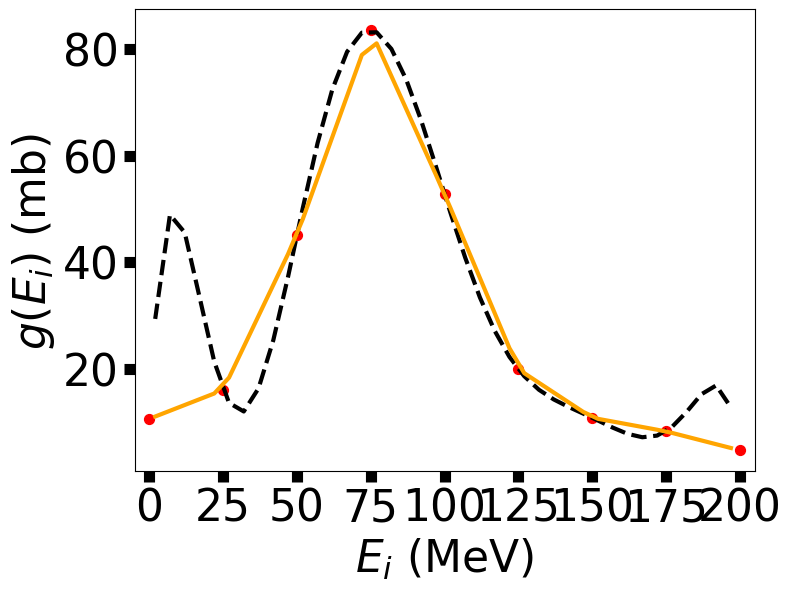

In [9]:
xvals = np.arange(0,225,25) #reset xvals to Table 2.1

fig = plt.figure(figsize=(aspect*6,6))
ax = fig.add_subplot(111)

#using the scatter function from matplotlib
ax.scatter(xvals,yvals,c='r',marker='o',s=50)

x_interp = np.arange(2,200,5)
g_interp = np.zeros(len(x_interp))
g_linear = np.zeros(len(x_interp))
for k in range(0,len(x_interp)):
    g_interp[k] = Lagrange_poly_approx(xvals, yvals, x_interp[k])
    g_linear[k] = linear_interp(xvals, yvals, x_interp[k])
ax.plot(x_interp,g_interp,'k--',lw=3)
ax.plot(x_interp,g_linear,'-',color='orange',lw=3)


ax.set_xlim(-5,205)
ax.set_xticks(xvals)
ax.set_xlabel("$E_i$ (MeV)",fontsize=fs)
ax.set_ylabel("$g(E_i)$ (mb)", fontsize=fs)
ax.tick_params(axis='both', direction='out',length = 8.0, width = 8.0,labelsize=fs)

fig.savefig("neutron_scattering_interp.png",bbox_inches='tight',dpi=300)

Notice that the Lagrange interpolation (dashed curve) works best near the middle and away from the end points. The linear interpolation (solid curve) goes through more of the points, but it's not very smooth.  A Theorist friend has predicted that the resonance energy (peak position) and full width at half max are 75 and 55 MeV, respectively.  **How can we compare values?**

In [10]:
half_max = np.max(g_interp)/2.
FWHM_idx = np.where(np.abs(g_interp-half_max)<5)[0] #search for values that satisfy the conditional |g-FWHM| < 5
FWHM = x_interp[FWHM_idx[-1]]-x_interp[FWHM_idx[1]] #excluded FWHM[0] because it is in the spurious region
print("Resonance Energy: ",x_interp[np.argmax(g_interp)]," FWHM: ",FWHM) #argmax returns the index of the max value

Resonance Energy:  77  FWHM:  60


Our interpolation produced similar values (77 vs. 75; 60 vs. 55).


## Cubic Splines

Recall that the Lagrange Interpolation method produces an ($n-1$) polynomial fit, where $n=4$ produces a cubic polynomial.  Using a cubic polynomial, with additional constraints that the first and second derivatives are continuous between intervals, makes the spline fit particularly eye-pleasing.  If the interpolated function is a *potential*, you can take the derivative to obtain the force.  The process of matching polynomials and their derivatives leads to many simultaneous equations to be solved.  This is tedious work for humans, yet easy for computers and popular for calculations and graphics.

The basic approximation of splines is the representation of the function $g(x)$ in the subinterval $[x_i,\:x_{i+1}]$ with a cubic polynomial:

\begin{align}
g(x) &\simeq g_i(x),\ \text{for } x_i \leq x \leq x_{i+1}, \\
g_i(x) &= g_i + g_i^\prime(x-x_i) + \frac{1}{2}g_i^{\prime\prime}(x-x_i)^2 + \frac{1}{6}g_i^{\prime\prime\prime}(x-x_i)^3.
\end{align}    

This shows that the coefficients in the polynomial are the values of $g(x)$ and its (first, second, and third) derivatives at the tabulated points.  Now we need to determine these derivatives in terms of the $N$ tabulated $g_i$ values.  As a result, we obtain the following boundary conditions:

$$g_i(x_{i+1}) = g_{i+1}(x_{i+1}),$$  

The $i{\rm th}$ spline as the end of its interval is equal to the $(i+1){\rm th}$ spline at the beginning of its interval.  For the derivatives, we have

\begin{align}
g_{x_i}^\prime(x_i) &= g_i^\prime(x_i),\qquad \text{(first derivatives)} \\
g_{i-1}^{\prime\prime}(x_i) &= g_i^{\prime\prime}(x_i),\qquad \text{(second derivatives)} \\
g_i{\prime\prime\prime} &\simeq \frac{g_{i+1}^{\prime\prime}-g_i^{\prime\prime}}{x_{i+1}-x_i}.\qquad \text{(third derivatives)}
\end{align}

If this is unclear, then you are not alone.  It takes some work to go through all the steps.  We are not trying to re-invent the wheel and thus, we will use a library from `scipy` to do the heavy lifting.  If you are still curious, then you can visit this [guide](https://en.wikiversity.org/wiki/Cubic_Spline_Interpolation).  Meanwhile, let's see how to use the `CubicSpine` library.


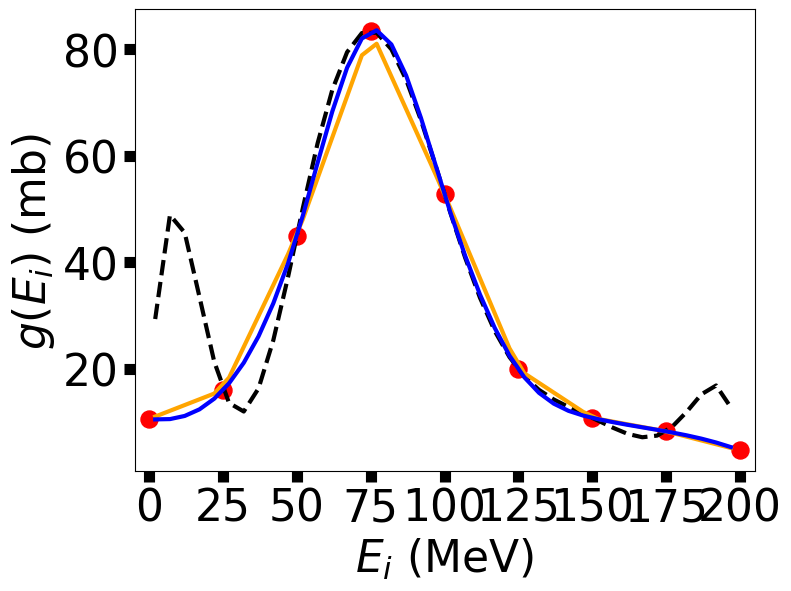

In [11]:
from scipy.interpolate import CubicSpline

fig = plt.figure(figsize=(aspect*6,6))
ax = fig.add_subplot(111)

#using the scatter function from matplotlib
ax.scatter(xvals,yvals,c='r',marker='o',s=150)

#x_interp, g_interp, and g_linear are defined in the previous section 
ax.plot(x_interp,g_interp,'k--',lw=3)
ax.plot(x_interp,g_linear,'-',color='orange',lw=3)

#Cubic Spline function from scipy
g_spline = CubicSpline(xvals,yvals) #returns a function
ax.plot(x_interp,g_spline(x_interp),'-',color='b',lw=3)


ax.set_xlim(-5,205)
ax.set_xticks(xvals)
ax.set_xlabel("$E_i$ (MeV)",fontsize=fs)
ax.set_ylabel("$g(E_i)$ (mb)", fontsize=fs)
ax.tick_params(axis='both', direction='out',length = 8.0, width = 8.0,labelsize=fs)

fig.savefig("neutron_scattering_spline.png",bbox_inches='tight',dpi=300)

## Data Fitting

A key skill for any scientist is to fit a model to data.  A "good fit" to experimental data can sometimes be difficult.  We will introduce the basics behind data fitting, where the field specific techniques will likely arise later in your career (academia or industry).  There are three main points to keep in mind:

1. Experimental data has errors, then the "best fit" in a statistical sense should **not** pass through all the data points.  
2. The model (theory) must be appropriate to the data being fit.  Mismatches between the model and data can provide information (i.e., pick a different model).  
3. Only in the simplest case (linear least-squares fit) can we write down a closed-form solution.  Most realistic problems are solved by *trial-and-error* search procedures that involve statistical sampling.

Suppose you have $N$ data values of the independent variable $y$ as a function of the dependent variable $x$ ($x_i,y_i\pm\sigma_i$), where the $\pm \sigma_i$ is the uncertainty in the *i*th value of $y$. Eventually, we will solve the problem where $y$ represents the number of decays for Ba-137 (using data from Chapter 1) and $x_i$ are the times.  In general, our goal is to determine how well a *model* ($y=g(x)$) can describe the data.  If we have a good reason that the correct model is identified, then the problem is finding the optimal parameters or constants for the model.  

We assume that the model $g(x)$ contains an additional dependance upon $M_p$ parameters $a_m = \left(a_1, a_2, \cdots,a_{M_p}\right)$.  These parameters are physical parts of the model, such as the size of a box, mass of a particle, or depth of a potential well.  For our problem, we will use the exponential decay function:

$$ N(t) = N_o e^{-t/\tau}, $$  

where the parameters are the lifetime $\tau$ and the initial decay rate $dN(0)/dt$.  In general, we indicate this as $g(x) = g(x; a_m)$.  We use the chi-square $\chi^2$ measure as a gauge of how well a model $g$ reproduces the data:

\begin{align}
\chi^2 = \sum_{i=1}^N \frac{(y_i-g(x_i; a_m))^2}{\sigma_i^2}, 
\end{align}

where the sum is over the $N$ data values.  The definition is such that the minimal $\chi^2$ (smaller values) are better fits.  Notice also that the 1/$\sigma_i^2$ weights the measurements with larger errors so they contribute less to $\chi^2$.  If the errors are not given in the data set, then you can use the standard error estimate $\sigma_x = \sigma/\sqrt{N}$ where $\sigma$ is the standard deviation.  If you are interested in other methods of error estimation, look at this introductory [article](https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60) from *towardsdatascience.com*.

**Least-squares fitting** refers to adjusting the model parameters until a minimum in $\chi^2$ is found.  In other words, it is searching for a minimum *absolute error* $(y_i-g(x_i; a_m))^2$ between the data points $y_i$ and the model $g(x_i; a_m)$.  Recall from *Calculus* that finding a minimum is taking the derivative and setting it equal to zero.  Therefore, we can express the derivative of $\chi^2$ with respect to the model parameters $a_m$ as:

\begin{align}
\frac{\partial [\chi^2]}{\partial a_m} = \displaystyle\sum_{i=1}^N\frac{[y_i-g(x_i)]}{\sigma_i^2}\frac{\partial g(x_i)}{\partial a_m} = 0,
\end{align}  

where $i$ refers to a loop over the data points and $a_m$ corresponds to the list of model parameters $\left(a_1,\cdots,a_{M_p}\right)$.  Typically this results in a sufficiently complicated dependence on the model parameters $a_m$ to produce a set of **non-linear** equations.  Thus, solutions are found by a *trial-and-error* search (i.e., test many possible solutions and use $\chi^2$ to sort them).  

### Least-squares Fitting: linear regression

Random errors can produce deviations between the model and the data points, where these errors are described by a Gaussian distribution.  As a heuristic, you know that your fit is good if the $\chi^2$ is approximately equal to the number of degrees of freedom ($N-M_p$).  

- $\chi^2<< N-M_p$: it doesn't mean that you have "great" model or really precise measurement; you probably have too many parameters (over-fitting) or large errors.
- $\chi^2 >> N-M_p$: the model may not be good, you may have underestimated your errors, or your errors have a bias (i.e., not random).

Let's start with a model that *linearly* depend on the model parameters:

$$ g(x; [a_1,a_2]) = a_1 + a_2x. $$

This is simply *linear regression*: there are $M_p = 2$ parameters with a slope $a_2$ and y-intercept $a_1$.  Even though there are only two parameters to determine, there still may be a large number $N$ of data points.  A unique solution is not possible unless the number of data point is equal equal to or greater than the number of parameters ($N>M_p$).  For this linear case, there are just two derivatives,

\begin{align}
\frac{\partial g(x_i)}{\partial a_1} &= 1, \\
\frac{\partial g(x_i)}{\partial a_2} &= x_i, 
\end{align}

and after substitution, the $\chi^2$ minimization equations can be solved:

\begin{align}
\frac{\partial[\chi^2]}{\partial a_1} &= \sum_{i=1}^N \frac{[y_i-a_1-a_2x_i]}{\sigma_i^2} = 0, \\ 
\frac{\partial[\chi^2]}{\partial a_2} &= \displaystyle\sum_{i=1}^N \frac{[y_i-a_1-a_2x_i]}{\sigma_i^2}x_i = 0.
\end{align}

Let's solve these equations for $a_1$ and $a_2$ using the average values ($\bar{x}$, $\bar{y}$):

\begin{align}
\bar{y}-a_1-a_2\bar{x} &= 0, \\
a_1 &= \bar{y} - a_2\bar{x}, \\  
a_2 &= \frac{\sum_i^N (x_i-\bar{x})(y_i-\bar{y})}{\sum_i^N (x_i-\bar{x})^2}.\quad \text{(best fit slope)}
\end{align}

See this [guide](https://towardsdatascience.com/linear-regression-using-least-squares-a4c3456e8570) for another approach.


<div align="center">

<iframe width="560" height="315"
src="https://www.youtube.com/embed/dTGqOj1NZwY"
frameborder="0" 
allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" 
allowfullscreen></iframe>

</div>

### Least-Squares Fitting: Implementation

Now, the theory behind least squares fitting needs to be interpreted and turned into code.  Part of this exercise will use the `curve_fit` library from `scipy` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).  First, let's import the Ba-137 data and plot it.

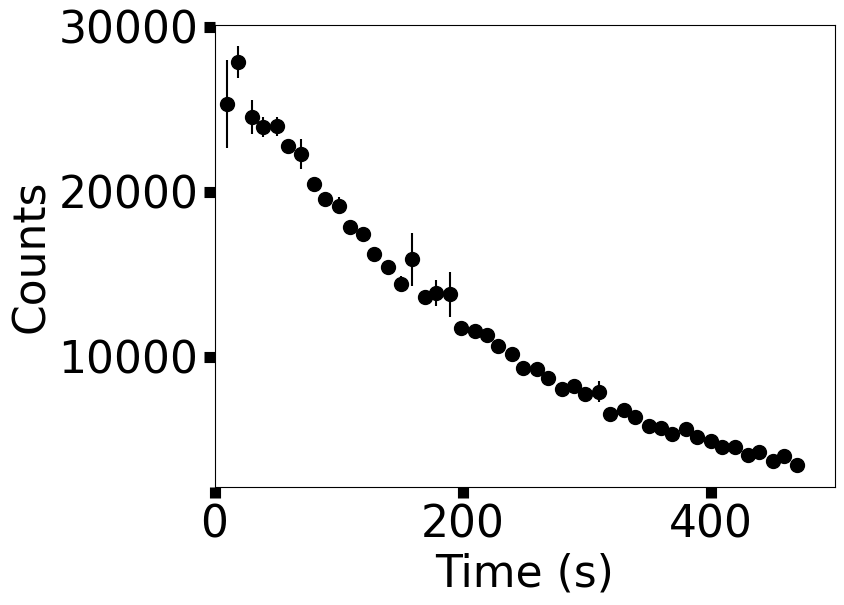

In [12]:
data_x,data_y,yerr = np.genfromtxt("Ba137_new.txt",delimiter=',',comments='#',unpack=True)
N = len(data_y)
#yerr = np.std(data_y)/np.sqrt(N)
generate_data = 'F'
if generate_data == 'T':
    out = open("Ba137_new.txt",'w')
    out.write("#Time (s), Counts\n")
    for r in range(0,N):
        Count = 29281*np.exp(-np.log(2)*data_x[r]/153.6)
        rand_count = Count*np.random.normal(1,0.05)
        out.write("%03i, %5i, %5i\n" % (data_x[r],rand_count,Count-rand_count))
    out.close()

fig = plt.figure(figsize=(aspect*6,6))
ax = fig.add_subplot(111)

ax.errorbar(data_x,data_y,yerr=np.abs(yerr),fmt='o',color='k',ms=10)


ax.set_xlim(0,500)
ax.set_xlabel("Time (s)",fontsize=fs)
ax.set_ylabel("Counts", fontsize=fs)
ax.tick_params(axis='both', direction='out',length = 8.0, width = 8.0,labelsize=fs)

fig.savefig("Ba137.png",bbox_inches='tight',dpi=300)

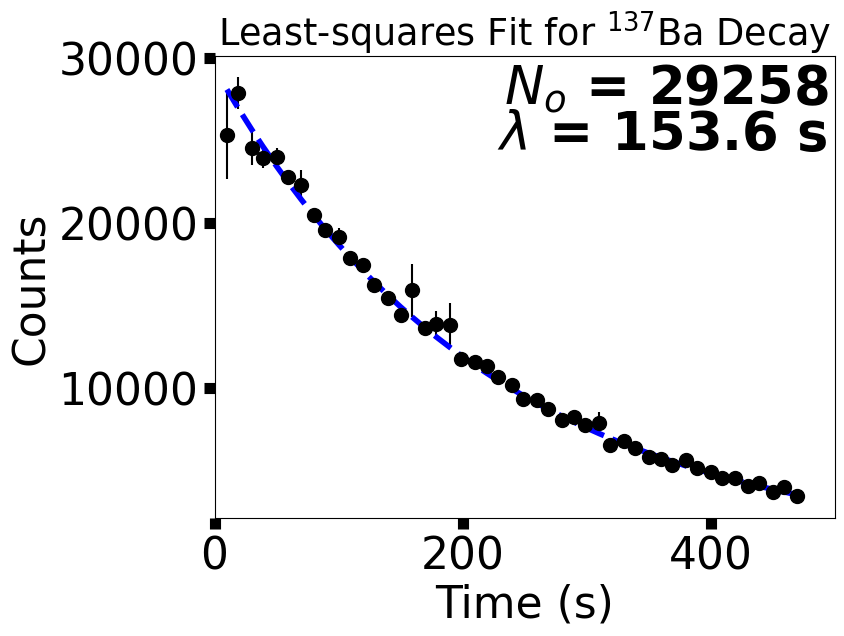

In [13]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 

def func(t,N_o,lam):
    #model for radioactive decay
    #t = time in sec
    #N_o = Initial number of parent particles
    #lam = half-life of Ba-137
    return N_o*np.exp(-np.log(2)*t/lam)

data_x,data_y,yerr = np.genfromtxt("Ba137_new.txt",delimiter=',',comments='#',unpack=True)
N = len(data_y)

#Using the curve_fit function from scipy.optimize library
#additional arguments can be found in the scipy.optimize documentation
popt, pcov = curve_fit(func,data_x,data_y,sigma=yerr)

fig = plt.figure(figsize=(aspect*6,6))
ax = fig.add_subplot(111)

ax.set_title("Least-squares Fit for $^{137}$Ba Decay")
ax.errorbar(data_x,data_y,yerr=np.abs(yerr),fmt='o',color='k',ms=10)
ax.plot(data_x,func(data_x,29375,153.1),'b--',lw=4)

ax.text(0.99,0.9,"$N_o$ = %5i" % popt[0],color='k',fontsize='xx-large',weight='bold',horizontalalignment='right',transform=ax.transAxes)
ax.text(0.99,0.8,"$\lambda$ = %3.1f s" % popt[1],color='k',fontsize='xx-large',weight='bold',horizontalalignment='right',transform=ax.transAxes)

ax.set_xlim(0,500)
ax.set_xlabel("Time (s)",fontsize=fs)
ax.set_ylabel("Counts", fontsize=fs)
ax.tick_params(axis='both', direction='out',length = 8.0, width = 8.0,labelsize=fs)

fig.savefig("Ba137_wModel.png",bbox_inches='tight',dpi=300)

We used the `curve_fit` function from `scipy.optimize` to generate a best bit curve to the data.  The `curve_fit` function returns two objects: 

1. an array of best fit parameters and 
2. a matrix estimating the covariance of the parameters.  
 
**What is the covariance?**  Mathematically, it is the mean (or expectation) of the product of the deviations along 2 or more dimensions.  Check out the [wikipedia](https://en.wikipedia.org/wiki/Covariance) article for more details.

Recall that the least-squares method is largely *trial-and-error* that uses the $\chi^2$ function to sort out the best fit solutions.  Therefore, there are many solutions that **fit** and the best-fit parameters can be tuned against those solutions (i.e., the $N_o$ can be tweaked and this changes the $\lambda$).  Suppose we have two parameters (X,Y), here is an example of some of the possibilities for the covariance:


```{figure-md} covariance-fig
<img src="covariance.png" alt="covariance"  width="600px">

Illustration of the sign of the covariance of two random variables. Image Credit: [Wikipedia:covariance](https://en.wikipedia.org/wiki/Covariance).
```

The leftmost plot shows a negative slope (or correlation) in the covariance, where the rightmost plot illustrates a positive slope.  The middle plot shows that the two parameters are uncorrelated (i.e., independent).  The `curve_fit` function returns a 2x2 matrix for the covariance of our decay model with a row and column for $N_o$ and $\lambda$, respectively.  The covariance of a parameter with itself is simply the estimated error in that parameter (e.g., Cov(X,X)=Var(X)=$\sigma^2_X$).  In this approach the error is assumed to be Gaussian, meaning that it symmetric in the $\pm \sigma_x$.

<div align="center">

<iframe width="560" height="315"
src="https://www.youtube.com/embed/Jl-Ye38qkRc"
frameborder="0" 
allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" 
allowfullscreen></iframe>

</div>

[[ 4.44173825e+03 -1.95903568e+01]
 [-1.95903568e+01  9.13808069e-02]]
sigma_N =  66.64636709486945
sigma_lam =  0.30229258492189953
N_o = 29258 +/-  66 particles
lambda = 153.6 +/- 0.3 sec


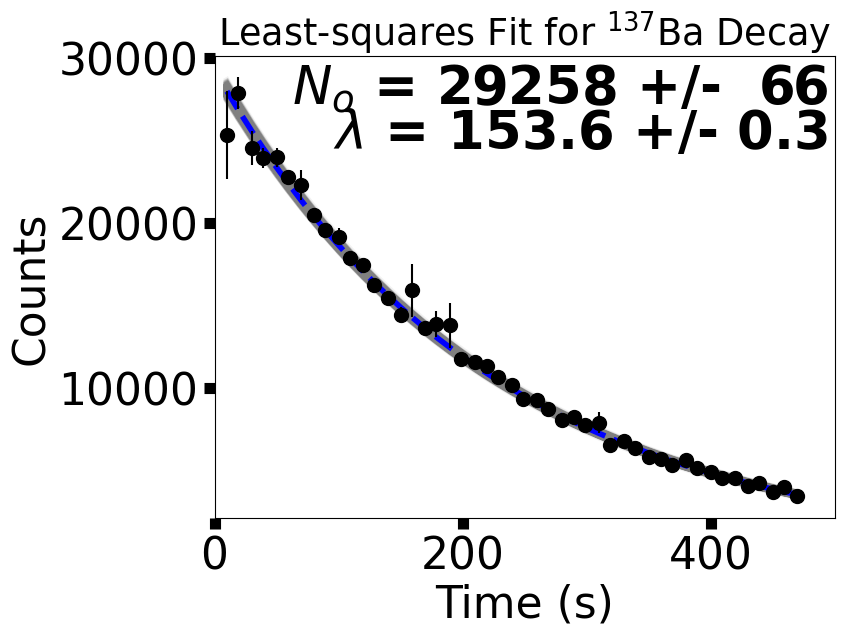

In [14]:
#The pcov matrix
print(pcov)
#Notice that the off diagonal terms are identical and negative

#Using the pcov matrix to calculate the best-fit parameters with errors
sigma_N = np.sqrt(pcov[0,0])
sigma_lam = np.sqrt(pcov[1,1])
print("sigma_N = ",sigma_N)
print("sigma_lam = ",sigma_lam)
#The reported error does **not** take significant figures into account (we must do that ourselves)

print("N_o = %5d +/- %3d particles" % (popt[0],sigma_N))
print("lambda = %3.1f +/- %3.1f sec" % (popt[1],sigma_lam))

fig = plt.figure(figsize=(aspect*6,6))
ax = fig.add_subplot(111)

ax.set_title("Least-squares Fit for $^{137}$Ba Decay")


#plot 3-sigma (99.8%) sample of solutions
for i in range(0,1000):
    samp_N = np.random.normal(popt[0],3*sigma_N)
    samp_lam = np.random.normal(popt[1],3*sigma_lam)
    ax.plot(data_x,func(data_x,samp_N,samp_lam),'-',color='gray',lw=4,alpha=0.1)
#plot best-fit and data
ax.plot(data_x,func(data_x,*popt),'b--',lw=4)
ax.errorbar(data_x,data_y,yerr=np.abs(yerr),fmt='o',color='k',ms=10)

ax.text(0.99,0.9,"$N_o$ = %5d +/- %3d" % (popt[0],sigma_N),color='k',fontsize='xx-large',weight='bold',horizontalalignment='right',transform=ax.transAxes)
ax.text(0.99,0.8,"$\lambda$ = %3.1f +/- %3.1f" % (popt[1],sigma_lam),color='k',fontsize='xx-large',weight='bold',horizontalalignment='right',transform=ax.transAxes)

ax.set_xlim(0,500)
ax.set_xlabel("Time (s)",fontsize=fs)
ax.set_ylabel("Counts", fontsize=fs)
ax.tick_params(axis='both', direction='out',length = 8.0, width = 8.0,labelsize=fs)

fig.savefig("Ba137_wModel_err.png",bbox_inches='tight',dpi=300)


### Maximum Likelihood Estimation

Another method of data fitting is to use maximum likelihood estimation (MLE).  This process is heavier on statistics, where I will show the basics.  The advantage of MLE is that you can better estimate the errors in the model parameters, especially when they are non-symmetric.  The good news is there is a python package called `emcee` or the *emcee hammer* (see the [documentation](https://emcee.readthedocs.io/en/stable/)).  This package allows you to employ different sampling methods and has quickly become a common tool in research (in astronomy).  

**To import emcee: it needs to be installed into your python environment through 'pip install emcee' or 'conda install -c conda-forge emcee' in the terminal.**  To install python packages in Google Colab, simply add `!` to the front to get `!pip install emcee`.

The Least-Squares method tries to solve the data fitting problem directly, where MLE takes a different approach.  MLE is concerned with the inverse problem: given the observed data $x = [x_i]_{i=1}^N$ and a model, find the parameters that yield a probability distribution function (pdf) that is *most likely* to represent the data.  The Likelihood function $\mathcal{L}$ is used to determine whether the trial parameters are likely to represent the data.  To sample the probability space more efficiently, the log-likelihood is used and we can construct a Gaussian that is analogous to $\chi^2$ by:

$$ \log \mathcal{L} = -\frac{1}{2}\displaystyle\sum_{i=1}^N \left[\frac{(y_i-g(x_i,a_m))^2}{\sigma_i^2} + \log(2\pi\sigma_i^2)\right], $$

where $log$ refers to the natural logarithm.  

You will notice that this looks much like the $\chi^2$, but it contains an extra 1/2 factor and an additional term.  The second term comes from the normalization factor for a Gaussian pdf.  

Besides the Likelihood function, there is the *prior* probability.  Priors are used when you have some prior knowledge about the data you are trying to model.  For example, using our data for Ba-137 we can reasonably suggest that the following condition: $25000 \leq N_o \leq 50000$.  We don't know which value within the interval (25,000--50,000) is more probable and therefore we call this a **uniform** prior, where values outside the conditions are given a penalty.  We can do the same kind of estimation for $\lambda$ to get: $75 \leq \lambda \leq 300$, since $\lambda$ is related to the half-life.  Now that we know about the Likelihood function and priors, let's get coding.

In [15]:
import emcee
import numpy as np

def log_prob(a_m,x,y,yerr):
    #Log Likelihood function given a set of model parameters a_m
    #x,y,yerr are arrays passed in as arguments (they are the same every time, only a_m changes)
    N_o, lam = a_m #unpack the model parameters
    model = func(x,N_o,lam) #evaluate the model using the guess for N_o, lam
    return -0.5*np.sum((y-model)**2/yerr**2 + np.log(2.*np.pi*yerr**2)) #Gaussian likelihood function

def log_prior(a_m):
    #Log Prior probability function (usually uniform) of the model parameters: a_m
    N_o, lam = a_m #upack the model parameters
    #uniform priors; penalty if not in the interval
    if not 25000 <= N_o <= 50000:
        return -np.inf
    if not 75 <= lam <= 300:
        return -np.inf
    return 0.

def lnprob(a_m,x,y,yerr):
    #Full probability function that combines the prior with the log likelihood
    #a_m = model parameters
    #x,y,yerr = time data, counts, and experimental errors on counts
    lp = log_prior(a_m) #get the log prior probability
    if not np.isfinite(lp): #check if the log_prior returned inf
        return -np.inf #stop checking; guess different model parameters
    return lp + log_prob(a_m,x,y,yerr) #return the probability to the sampler


#emcee utilizes walkers which is like taking a bag full of guesses and evaluating them all at once
nwalkers = 32 #you shouldn't increase this unless using a cluster
ndim = 2 #number of model parameters

init_state = []
for n in range(0,nwalkers):
    #initial guess for the model parameters distributed among the walkers
    temp = np.array([27000,100])*np.random.normal(1,0.1)
    init_state.append(temp)

#invoke the default sampler;  more details in the documentation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data_x, data_y, yerr))
sampler.run_mcmc(init_state, 5000, progress=True,skip_initial_state_check=True) #run the sampler

#discard the first 100 samples as burn-in and only take every 15th iteration
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\satur\anaconda3\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:07<00:00, 630.20it/s]


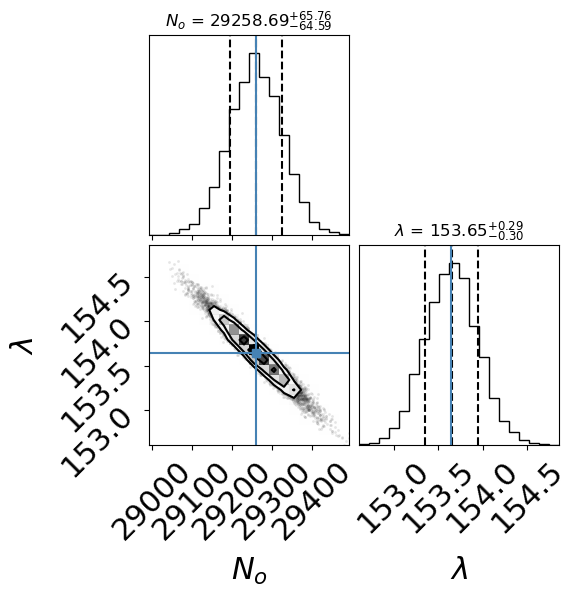

In [16]:
import corner

#show the correlation between parameters
labels = ["$N_o$","$\lambda$"]
fig = corner.corner(flat_samples, labels=labels, truths=popt,quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12},labelpad=0.25)

In the above figure (created with [corner](https://corner.readthedocs.io/en/latest/index.html)), we recover a result that is consistent with the Least-Squares approach (i.e., overlapping within the 1-sigma errors).  **Note that this result is the raw output and you need to report values with the correct number of significant digits.**



## Problems
Complete the following problems in a Jupyter notebook, where you will save your results as an external file (*.png).

Create a $\LaTeX$ document with:

- an abstract summary
- sections for each problem that **state** the problem, **explain** your approach to solving the problem, and **display** the results
- include a reference for each solution (this can be from a textbook) 

```{admonition} Problem 1
**Consider the set of data points** (x, y): {(.69, 4.60), (.12, 3.71), (.21, 3.95), (.63, 4.33), (.66, 4.82), (.53, 4.13), (.84, 5.26)}. 

**(a)** Find the line of least squares fit for this data.  
**(b)** Add 1 to the x-coordinate of each of the points and find the line of least squares fit for this modified data.  
**(c)** Add 1 to the y-coordinate of each of the original points and find the line of least squares fit for this modified data.  
```

````{admonition} Problem 2
**Consider the following data points:**

```{list-table}
:header-rows: 1

* - t
  - y
* - 0.25
  - 1.58
* - 1.88
  - 6.35
* - 0.56
  - 1.77
* - 0.82
  - 2.18
* - 1.92
  - 6.63
* - 0.99
  - 2.11
* - 1.15
  - 3.61
* - 2.09
  - 8.91
* - 1.47
  - 5.07
```

**Find a curve that best fits this data of the form: $y = a e^{b t}$.**
````

```{admonition} Problem 3
**Consider the data points from Problem 2 corresponds to the measurement of two quantities that are known to satisfy a power relationship, $y = a x^k$.**  Use the method of least squares to find the appropriate values for the constants $a$ and $k$.  Graph the resulting curve along with the original data.
```